In [2]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='c7c1ae2b-bfa0-4fce-b95d-f06ef8560799', project_access_token='p-c49bb9e197d1cb449f0dd434e7ee3ce1870f5623')
pc = project.project_context


# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones

### Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

<hr>

### Instalación de Librerias

In [3]:
!pip install scikit-learn --upgrade
!pip install xgboost --upgrade
!pip install imblearn --upgrade

Requirement already up-to-date: scikit-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.23.2)
Requirement already up-to-date: xgboost in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.2.0)
Requirement already up-to-date: imblearn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.0)


In [11]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

### Descargando el dataset csv desde Github

In [12]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv

--2020-09-10 17:06:06--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751735 (1.7M) [text/plain]
Saving to: ‘reto-4-compu-train.csv.6’

100%[======================================>] 1,751,735   --.-K/s   in 0.05s   

2020-09-10 17:06:06 (36.1 MB/s) - ‘reto-4-compu-train.csv.6’ saved [1751735/1751735]



In [13]:
df = pd.read_csv(r'reto-4-compu-train.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### Acerca del Dataset

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 17 columns):
EFECTIVO                     7986 non-null float64
CXC                          7968 non-null float64
INVENTARIO                   8000 non-null float64
EQ_OFICINA                   7945 non-null float64
EQ_TRANSPORTE                7988 non-null float64
TERRENOS_Y_CONSTRUCCIONES    8038 non-null float64
CXP                          7934 non-null float64
CONTRIBUCIONES_X_PAGAR       8052 non-null float64
ANTICIPOS_CTE                7976 non-null float64
CAP_SOCIAL                   8036 non-null float64
UTILIDADES_ACUMULADAS        7993 non-null float64
UTILIDAD_O_PERDIDA           8031 non-null float64
TOTAL_VENTAS                 7941 non-null float64
TOTAL_COMPRAS                7908 non-null float64
UTILIDAD_BRUTA               7971 non-null float64
TOTAL_GASTOS                 7943 non-null float64
OBJETIVO                     9400 non-null object
dtypes: float64(16), object

Las variables son todas numericas. Solo nuestra variable TARGET (Prestamo aprobado o posible incumplimiento financiero) es the tipo float.

La función describe() de abajo muestra varias estadisticas del dataset.

In [15]:
df.describe()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
count,7.986000e+03,7.968000e+03,8.000000e+03,7.945000e+03,7.988000e+03,8.038000e+03,7.934000e+03,8.052000e+03,7.976000e+03,8.036000e+03,7.993000e+03,8.031000e+03,7.941000e+03,7.908000e+03,7.971000e+03,7.943000e+03
mean,1.720915e+06,1.561073e+07,1.098941e+07,4.341284e+06,1.321588e+06,6.198420e+05,2.275234e+07,4.109997e+05,2.635145e+06,3.325138e+06,4.240122e+06,-2.090086e+06,1.017051e+08,1.211510e+08,1.702067e+07,1.620236e+07
std,5.958844e+06,1.980334e+07,1.541956e+07,1.885512e+07,1.398674e+06,6.202347e+06,2.810091e+07,6.311683e+05,3.828127e+06,4.122756e+06,1.066916e+07,2.439421e+06,1.148423e+08,3.320798e+08,1.710116e+07,1.341951e+07
min,2.591455e+03,3.282261e+01,5.019700e-02,2.974216e+02,1.698222e+02,-1.577708e+07,1.276200e+01,5.638191e+03,4.495763e+00,2.334091e+00,-4.029189e+07,-8.716171e+06,7.154203e+03,1.458903e+05,2.408107e+03,3.979024e+03
25%,1.874601e+05,2.362067e+06,9.281351e+05,1.769855e+05,3.433503e+05,-3.874056e+06,3.711720e+06,1.113298e+05,3.813363e+05,5.629920e+05,-3.025772e+06,-3.824858e+06,2.303181e+07,1.214764e+07,4.836037e+06,6.104123e+06
50%,5.112329e+05,8.255125e+06,4.810330e+06,6.529255e+05,8.630635e+05,1.828932e+06,1.286143e+07,2.288855e+05,1.235872e+06,1.870131e+06,4.119952e+06,-1.629044e+06,6.309045e+07,3.473485e+07,1.181114e+07,1.272461e+07
75%,1.432613e+06,2.160462e+07,1.474278e+07,2.430901e+06,1.827559e+06,5.955197e+06,3.097250e+07,4.690705e+05,3.273238e+06,4.536913e+06,1.140550e+07,-7.368186e+03,1.378293e+08,1.007433e+08,2.352766e+07,2.260017e+07
max,3.343603e+08,2.135761e+08,1.664338e+08,5.913821e+08,1.290365e+07,9.031323e+06,2.644946e+08,1.618323e+07,4.291686e+07,4.116688e+07,4.056842e+07,1.214191e+06,1.151511e+09,1.000136e+10,1.438985e+08,9.763166e+07


Analizo balanceo del dataset

In [16]:
from collections import Counter
counter = Counter(df.OBJETIVO)
for k,v in counter.items():
	per = v / len(df.OBJETIVO) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=Aceptado, n=8873 (94.394%)
Class=Sospechoso, n=527 (5.606%)


Claramente esta desbalanceado.
De lo que se desprende que debemos balancear el dataset, con alguna tecnica de resampling(nos podemos ayudar de librerias como imblearn, usando SMOTE) o bien algun metodo que adminta el weigth the las clases

<hr>

## Pre-procesando el dataset antes del entrenamiento


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

In [18]:
# Creación de instancias de una transformación DropColumns
rm_columns = DropColumns(
    columns=["UTILIDAD_BRUTA", "CXC", "CAP_SOCIAL", "EQ_OFICINA", "TOTAL_GASTOS", ]  # Esta transformación toma como parámetro una lista con los nombres de las columnas no deseadas
    #columns=["UTILIDAD_BRUTA", "TOTAL_COMPRAS", "EQ_OFICINA", "CXC"]  # Esta transformación toma como parámetro una lista con los nombres de las columnas no deseadas
)

print(rm_columns)

DropColumns(columns=['UTILIDAD_BRUTA', 'CXC', 'CAP_SOCIAL', 'EQ_OFICINA',
                     'TOTAL_GASTOS'])


In [19]:
# Ver las columnas del conjunto de datos original
print("Columnas del conjunto de datos original: \n")
print(df.columns)

# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df
    ),
)

# Ver las columnas del conjunto de datos transformado
print("\n\nColumnas del conjunto de datos después de la transformación ``DropColumns``: \n")
print(df2.columns)

Columnas del conjunto de datos original: 

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


Columnas del conjunto de datos después de la transformación ``DropColumns``: 

Index(['EFECTIVO', 'INVENTARIO', 'EQ_TRANSPORTE', 'TERRENOS_Y_CONSTRUCCIONES',
       'CXP', 'CONTRIBUCIONES_X_PAGAR', 'ANTICIPOS_CTE',
       'UTILIDADES_ACUMULADAS', 'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS',
       'TOTAL_COMPRAS', 'OBJETIVO'],
      dtype='object')


#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

In [20]:
# Definiendo las variables features y target (removed CXC and CXP)

features = df2[[column for column in df2.columns if "OBJETIVO" not in column]]
target = df2["OBJETIVO"]  ## No cambie la variable target!

#### División en 80% entrenamiento y 20% pruebas

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.001)

#### Procesando valores NaN

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada SimpleImputer.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Se obtpa por usar usar el 'mean', ya que poner a cero no es buena practica, y tenemos todos valores cont

In [22]:
# Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(X_train.isnull().sum(axis = 0)))

# Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='mean',  # la estrategia elegida es cambiar el valor faltante por 'mean'
    verbose=0,
    copy=True
)

X_train = pd.DataFrame(data=si.fit_transform(X=X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=si.transform(X=X_test), columns=X_train.columns)

# Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_2)
print("\n\nValores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(X_train.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

EFECTIVO                     1414
INVENTARIO                   1399
EQ_TRANSPORTE                1410
TERRENOS_Y_CONSTRUCCIONES    1360
CXP                          1462
CONTRIBUCIONES_X_PAGAR       1346
ANTICIPOS_CTE                1421
UTILIDADES_ACUMULADAS        1407
UTILIDAD_O_PERDIDA           1368
TOTAL_VENTAS                 1458
TOTAL_COMPRAS                1491
dtype: int64



Valores nulos en el conjunto de datos después de la transformación SimpleImputer: 

EFECTIVO                     0
INVENTARIO                   0
EQ_TRANSPORTE                0
TERRENOS_Y_CONSTRUCCIONES    0
CXP                          0
CONTRIBUCIONES_X_PAGAR       0
ANTICIPOS_CTE                0
UTILIDADES_ACUMULADAS        0
UTILIDAD_O_PERDIDA           0
TOTAL_VENTAS                 0
TOTAL_COMPRAS                0
dtype: int64



#### Escalado de valores (No lo uso, no note mejora)


In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = pd.DataFrame(X_train, columns=features.columns)
X_test = pd.DataFrame(X_test, columns=features.columns)

In [23]:
X_train.tail()

,EFECTIVO,INVENTARIO,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS
9385,2.614698e+05,2.390011e+06,1.327998e+06,7590067.527,1.011683e+07,4.837015e+04,6.592381e+05,4.238903e+06,-1.942255e+06,1.017156e+08,1.423079e+07
9386,6.728131e+06,6.998789e+07,5.499852e+06,2115371.599,1.236459e+08,1.161683e+06,1.039174e+07,2.345614e+07,-6.897561e+06,1.017156e+08,1.212039e+08
9387,1.699813e+05,2.837238e+03,1.106306e+06,-2122120.171,2.275112e+07,1.053401e+05,6.472184e+04,-5.544367e+06,1.114639e+06,8.470916e+06,2.368100e+06
9388,6.447074e+06,1.099143e+07,2.765976e+06,-3488892.190,4.878367e+07,2.487506e+05,4.867058e+06,6.078520e+06,-1.881330e+06,1.839877e+08,3.381680e+08
9389,8.717752e+05,1.888310e+06,7.899983e+05,-4467781.811,2.275112e+07,1.842799e+05,1.814690e+06,6.174565e+06,-5.749115e+05,6.664089e+07,2.461770e+07


#### Balancedo de la data(NO SE USA)


In [ ]:
# # Distribucion de TARGET
# from collections import Counter
# counter = Counter(y_train)
# for k,v in counter.items():
# 	per = v / len(y_train) * 100
# 	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
 

# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTETomek

# smote = SMOTE()

# X_sm, y_sm = smote.fit_sample(X_train, y_train)

# X_train = pd.DataFrame(data=X_sm, columns=X_train.columns)
# # y_train = pd.DataFrame(data=y_sm, columns=['OBJETIVO'])
# y_train = y_sm

# # Distribucion de TARGET
# from collections import Counter
# counter = Counter(y_train)
# for k,v in counter.items():
# 	per = v / len(y_train) * 100
# 	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

## Entrenamiento del modelo


#### Entrenando un modelo

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.neural_network import MLPClassifier

dtc_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, criterion='gini',
       gamma=0.1, gpu_id=-1, importance_type='gain',
       interaction_constraints='', learning_rate=0.2, max_delta_step=0,
       max_depth=25, max_features='auto', min_child_weight=3,
       min_samples_leaf=3, min_samples_split=5,
       monotone_constraints='()', n_estimators=100, n_jobs=0,
       num_parallel_tree=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=35.34, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)
model = dtc_model.fit(X_train, y_train)

[17:08:24] WARNING: ../src/learner.cc:516: 
Parameters: { criterion, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




#### Haciendo una predicción con el set de prueba

In [ ]:
y_pred = dtc_model.predict(X_test)
print(y_pred)
print(y_test)

#### Analizar la calidad del modelo a través de la matriz de confusión

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=1.000\nPrecision=1.000\nRecall=1.000\nF1 Score=1.0')

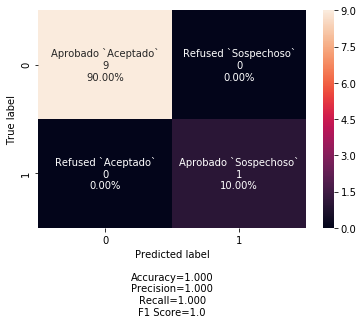

In [19]:

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

#### Metricas interesantes

In [20]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

def print_score(model, X_train, y_train, X_test, y_test):
    print('R^2 for training:    ', model.score(X_train, y_train))
    print('R^2 for validation:  ', model.score(X_test, y_test))

    
    y_pred = model.predict(X_test)
    if hasattr(model, 'oob_score_'): 
        print('OoB score:           ', model.oob_score_)
    
    print(classification_report(y_test, y_pred,digits=5, target_names=['Aceptado', 'Sospechoso']))

# evaluate a logistic regression model using repeated k-fold cross-validation
# https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from numpy import mean
from numpy import std

def evaluate_model(model, X, y, repeats):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_validate(model, X, y, scoring=['roc_auc', 'f1_macro'], cv=cv, n_jobs=-1)
  print('Mean ROC AUC: %.3f (%.3f)' % (mean(scores['test_roc_auc']), std(scores['test_roc_auc'])))
  print('Mean f1_macro: %.3f (%.3f)' % (mean(scores['test_f1_macro']), std(scores['test_f1_macro'])))
  return


print_score(dtc_model, X_train, y_train, X_test, y_test)
from sklearn.pipeline import Pipeline
pipe = Pipeline([('si', si), ('model', dtc_model)])
evaluate_model(dtc_model, features, target, 5)


R^2 for training:     1.0
R^2 for validation:   1.0
              precision    recall  f1-score   support

    Aceptado    1.00000   1.00000   1.00000         9
  Sospechoso    1.00000   1.00000   1.00000         1

    accuracy                        1.00000        10
   macro avg    1.00000   1.00000   1.00000        10
weighted avg    1.00000   1.00000   1.00000        10

Mean ROC AUC: nan (nan)
Mean f1_macro: nan (nan)


##### ¡ATENCIÓN! Su puntuación en este desafío de clasificación se basará en la puntuación F1 del modelo al predecir el dataset de evaluación.

<hr>

### Analisis de Features

#### Feature importance

In [ ]:
import pandas as pd
from matplotlib import pyplot

(pd.Series(dtc_model.feature_importances_, index=X_train.columns)
   .nlargest(20)
   .plot(kind='barh'))

#### Denograma de correlacion

In [ ]:
from scipy.cluster import hierarchy as hc
import scipy
import matplotlib.pyplot as plt

corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4) # correlation matrix
corr_condensed = hc.distance.squareform(1 - corr)         # distances matrix
z = hc.linkage(corr_condensed, method='average')          # hierarchical/agglomerative clustering

fig = plt.figure(figsize=(32,20))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

#### Testing Removiendo Columnas

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

for c in (X_train.columns):
    X_train_rm = X_train.copy()
    X_train_rm = X_train_rm.drop(c, axis=1)
    print("Metricas removiendo: {}".format(c))
    model = model.fit(X_train_rm, y_train)
    print_score(model, X_train_rm, y_train, X_test.drop(c, axis=1), y_test)
    evaluate_model(model, features.drop(c, axis=1), target, 5)


#### Hypertunning

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

param_space = {
        #"bootstrap": [True],
        #"oob_score": [True],
        "criterion": ['entropy', 'gini'],
        "max_depth": [None, 6, 8, 10, 12, 14, 15, 20, 25],
        "max_features": ['auto', 'sqrt','log2'],
        "min_samples_leaf": [2, 3, 4],
        "min_samples_split": [2, 3, 4, 5],
        "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
        "min_child_weight" : [ 1, 3, 5, 7 ],
        "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
        #"n_estimators": [10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}


rand_search = RandomizedSearchCV(dtc_model, param_space,
                                        n_iter=32,
                                        scoring=make_scorer(f1_score, pos_label='Sospechoso'),
                                        verbose=True,
                                        cv=5,
                                        n_jobs=-1,
                                        #random_state=5
                                  )

rand_search.fit(X_train, y_train)
print(rand_search.best_params_)
print(rand_search.best_estimator_)
print(rand_search.best_score_)

#### Testeo cambiando el peso de la clase

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

def testeo_peso():
  for k in range(1,80, 5):
      model_peso = XGBClassifier(scale_pos_weight=k)
      print("Metricas k: {}".format(k))
      #print_score(model, X_train_rm, y_train, X_test.drop(c, axis=1), y_test)
      evaluate_model(model_peso, features.copy(), target.copy(), 5)

testeo_peso()

Metricas k: 1


KeyboardInterrupt: 

## Puntuación de los datos necesarios para entregar la solución

Como entrega de su solución, esperamos que los resultados se clasifiquen en el siguiente conjunto de datos llamado "to_be_scored_compusoluciones.csv":

### Descarga la "hoja de evaluación"

In [22]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_compusoluciones.csv')
df_to_be_scored.tail()

--2020-09-10 16:14:30--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100124 (98K) [text/plain]
Saving to: ‘to_be_scored_compusoluciones.csv’

100%[======================================>] 100,124     --.-K/s   in 0.006s  

2020-09-10 16:14:30 (15.5 MB/s) - ‘to_be_scored_compusoluciones.csv’ saved [100124/100124]



,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
595,3.893725e+06,5.279410e+06,9.811669e+02,1.757291e+07,3.989011e+06,-1.545727e+07,2.497177e+06,103003.8264,2402813.337,NaN,1.751228e+07,-4050340.635,8.830412e+07,1.147548e+08,NaN,1.858752e+06
596,8.806031e+05,3.354813e+07,NaN,5.241604e+06,NaN,-1.727618e+06,4.021914e+07,821297.6732,3154291.078,NaN,1.636395e+07,-2394015.114,1.257229e+08,7.169861e+07,2.675382e+07,2.455403e+07
597,NaN,2.711050e+07,3.260820e+06,4.681080e+06,NaN,-3.291876e+06,3.763157e+07,NaN,1861471.266,942635.7885,7.126997e+06,NaN,6.531900e+07,1.014415e+08,2.333685e+07,NaN
598,7.443979e+06,4.076322e+07,6.408235e+06,1.507174e+07,6.257927e+05,-7.237902e+06,6.080636e+07,NaN,5220998.681,NaN,9.928204e+06,-3351032.988,9.340985e+07,1.571700e+08,3.062958e+07,3.042192e+07
599,5.611681e+05,6.438914e+06,3.867058e+06,4.545890e+05,1.949220e+06,-3.280783e+06,NaN,427294.9401,3954071.593,532328.4053,1.823676e+07,-5664180.434,1.059266e+08,5.820347e+07,5.238135e+05,2.470879e+06


# ¡Atención!

El Dataframe ``to_be_scored_compusoluciones`` es su "hoja de evaluación". Tenga en cuenta que a la columna "OBJETIVO" le faltan datos en este ejemplo, que luego no se pueden usar para entrenar modelos de aprendizaje supervisado.

In [23]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
EFECTIVO                     511 non-null float64
CXC                          511 non-null float64
INVENTARIO                   511 non-null float64
EQ_OFICINA                   505 non-null float64
EQ_TRANSPORTE                513 non-null float64
TERRENOS_Y_CONSTRUCCIONES    513 non-null float64
CXP                          523 non-null float64
CONTRIBUCIONES_X_PAGAR       499 non-null float64
ANTICIPOS_CTE                515 non-null float64
CAP_SOCIAL                   504 non-null float64
UTILIDADES_ACUMULADAS        496 non-null float64
UTILIDAD_O_PERDIDA           514 non-null float64
TOTAL_VENTAS                 506 non-null float64
TOTAL_COMPRAS                527 non-null float64
UTILIDAD_BRUTA               501 non-null float64
TOTAL_GASTOS                 510 non-null float64
dtypes: float64(16)
memory usage: 75.1 KB


<hr>

# ¡Atención!

# Para aplicar su modelo y clasificar la hoja de evaluación, primero debe aplicar las mismas transformaciones de columnas que aplicó al conjunto de datos de entrenamiento.

# No elimine ni agregue líneas a la hoja de respuestas.

# No cambie el orden de las líneas en la hoja de respuestas.

# Al final, se deben clasificar las 600 entradas, con los valores calculados en la columna "target"

<hr>

En la celda de abajo, repetimos rápidamente los mismos pasos de preprocesamiento usados ​​en el ejemplo dado con el árbol de decisiones

In [ ]:
# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df_to_be_scored_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_to_be_scored
    ),
)
# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df_to_be_scored_3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df_to_be_scored_2
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df_to_be_scored_2.columns  # las columnas originales deben conservarse en esta transformación
)

df_to_be_scored_3.tail()

In [25]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = dtc_model.predict(df_to_be_scored_3)

In [26]:
# Agregando las respuestas en la columna "target"
df_to_be_scored_3['target'] = y_pred
df_to_be_scored_3.tail()

,EFECTIVO,INVENTARIO,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,target
595,3.893725e+06,9.811669e+02,3.989011e+06,-1.545727e+07,2.497177e+06,103003.826400,2402813.337,1.751228e+07,-4.050341e+06,8.830412e+07,1.147548e+08,Sospechoso
596,8.806031e+05,1.099085e+07,1.320866e+06,-1.727618e+06,4.021914e+07,821297.673200,3154291.078,1.636395e+07,-2.394015e+06,1.257229e+08,7.169861e+07,Aceptado
597,1.720859e+06,3.260820e+06,1.320866e+06,-3.291876e+06,3.763157e+07,410928.686874,1861471.266,7.126997e+06,-2.089589e+06,6.531900e+07,1.014415e+08,Aceptado
598,7.443979e+06,6.408235e+06,6.257927e+05,-7.237902e+06,6.080636e+07,410928.686874,5220998.681,9.928204e+06,-3.351033e+06,9.340985e+07,1.571700e+08,Aceptado
599,5.611681e+05,3.867058e+06,1.949220e+06,-3.280783e+06,2.275989e+07,427294.940100,3954071.593,1.823676e+07,-5.664180e+06,1.059266e+08,5.820347e+07,Sospechoso


### Guardar la hoja de respuestas como un archivo .csv para enviar
**SI YA TIENE UN DATA ASSET CON EL NOMBRE `results.csv` EN ESTE PROYECTO O EN OTRO PROYECTO DE WATSON STUDIO DEBE BORRAR EL ARCHIVO ANTES DE CORRER LA SIGUIENTE CELDA O TENDRA EL ERROR: _RuntimeError: File 'results.csv' already exists in storage._**

In [27]:
project.save_data(file_name="results.csv", data=df_to_be_scored_3.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'desafio4wsproject-donotdelete-pr-2hjxj6gsqvu9tz',
 'asset_id': '2e072e8e-f738-4d31-8afb-b0dbfaa399c8'}

# Atención

# La ejecución de la celda anterior creará un nuevo "data asset" en su proyecto de Watson Studio. Deberá descargar este archivo junto con este cuaderno y crear un archivo zip con **results.csv** y **notebook.ipynb** para enviarlo. (los archivos deben tener este nombre)

<hr>

## ¡Felicitaciones! 

Si ya está satisfecho con su solución, vaya a la página siguiente y envíe los archivos necesarios para su envío.

# https://compusoluciones.maratona.dev